In [20]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler



# Detecting market regimes

In [11]:
df = pd.read_csv('data/data_preprocessed.csv', index_col=0, parse_dates=True)
log_returns = np.log(df / df.shift(1)).dropna()

In [ ]:
# Cross-sectional features per day

features = pd.DataFrame(index=log_returns.index)
features['mean_return']  = log_returns.mean(axis=1)
features['volatility']   = log_returns.std(axis=1)
features['median_return']= log_returns.median(axis=1)
features['iqr']          = log_returns.quantile(0.75, axis=1) \
                          - log_returns.quantile(0.25, axis=1)
features['skewness']     = log_returns.skew(axis=1)
features['kurtosis']     = log_returns.kurtosis(axis=1)
features['up_frac']      = (log_returns > 0).mean(axis=1)  

In [13]:
features

,mean_return,volatility,median_return,iqr,skewness,kurtosis,up_frac
timestamp,,,,,,,
2017-03-08,-0.012348,0.025446,-0.006839,0.019104,-1.385336,4.323977,0.248521
2017-03-09,-0.004321,0.013187,-0.002043,0.010747,-2.260932,16.493376,0.331361
2017-03-14,0.001178,0.019119,0.000183,0.012416,-2.076892,11.774861,0.550296
2017-03-20,0.011657,0.030887,0.008469,0.019382,-0.169989,11.080832,0.810651
2017-03-21,-0.007886,0.023945,-0.006696,0.021551,0.131815,4.879654,0.325444
...,...,...,...,...,...,...,...
2023-01-05,-0.003569,0.029990,-0.003061,0.018009,-2.391099,20.445876,0.343195
2023-01-06,0.014127,0.021099,0.016164,0.014673,-1.074715,4.349539,0.881657
2023-01-09,0.013946,0.032685,0.012177,0.020558,-0.674809,7.130068,0.822485


In [14]:
# Cluster days into 3 regimes
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(features)

# Map cluster IDs → regime names (bear < risky < bull by mean_return)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=features.columns)
order = centers['mean_return'].sort_values().index.tolist()
regime_map = {
    order[0]: 'Bear',     
    order[1]: 'Risky',   
    order[2]: 'Bull'     
}
regimes = pd.Series(labels, index=features.index).map(regime_map)


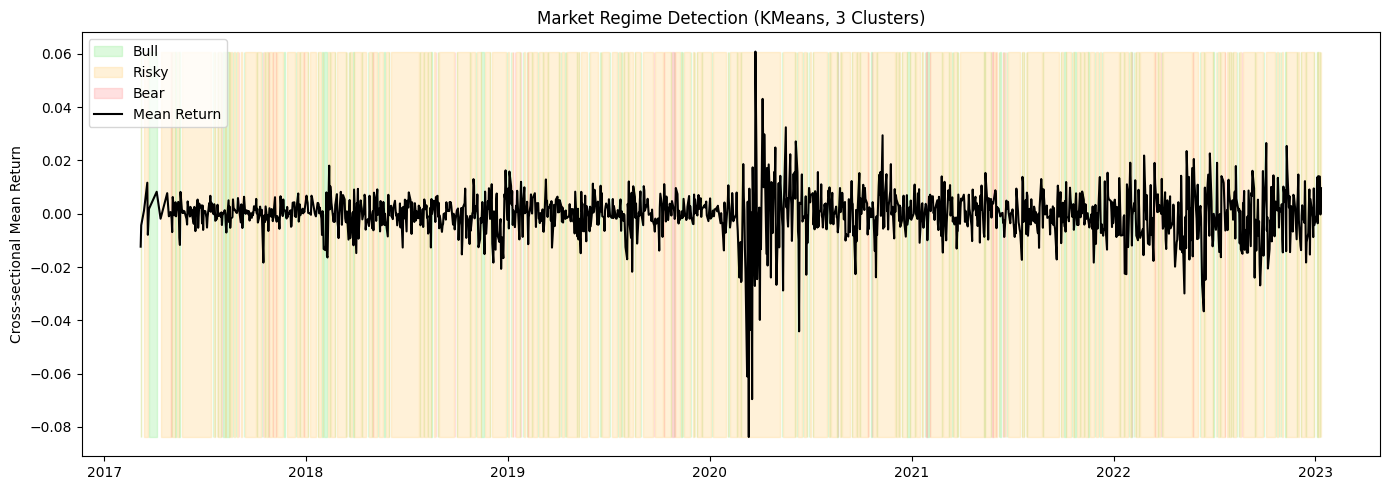

In [15]:
# plotting
plt.figure(figsize=(14,5))

ymin, ymax = features['mean_return'].min(), features['mean_return'].max()
for regime, color in zip(['Bull','Risky','Bear'], ['#90ee90','#ffd27f','#ff9999']):
    mask = regimes == regime
    plt.fill_between(
        features.index, ymin, ymax,
        where=mask, color=color, alpha=0.3,
        label=regime
    )

plt.plot(features.index, features['mean_return'], color='k', lw=1.5, label='Mean Return')

plt.title('Market Regime Detection (KMeans, 3 Clusters)')
plt.ylabel('Cross-sectional Mean Return')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [16]:
# Silhouette score
sil_score = silhouette_score(features, labels)
print(f"Silhouette score: {sil_score:.3f}")

Silhouette score: 0.698


In [21]:
# Inspect cluster centers in original feature space
centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=features.columns
)
print("\nCluster centers:\n", centers)

NameError: name 'scaler' is not defined

In [ ]:


# 7. (Optional) Visualize first two features colored by cluster
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
for lbl, color in zip([0,1,2], ['tab:blue','tab:orange','tab:green']):
    mask = (labels == lbl)
    plt.scatter(
        features.loc[mask,'volatility'],
        features.loc[mask,'mean_return'],
        s=10, alpha=0.6, color=color, label=f'Cluster {lbl}'
    )
plt.xlabel('Volatility')
plt.ylabel('Mean Return')
plt.title('Clusters with Expanded Features')
plt.legend()
plt.tight_layout()
plt.show()


Cluster centers:
    mean_return  volatility  median_return       iqr  skewness   kurtosis  \
0    -0.000041    0.021093       0.000069  0.015718 -0.069511   6.417242   
1    -0.000830    0.037645       0.000547  0.012895 -2.553216  72.009119   
2     0.000001    0.023704      -0.000002  0.012713 -0.242358  24.441982   

    up_frac  
0  0.520616  
1  0.516124  
2  0.515755  
